# Imports

In [1]:
# imports, including functions provided with the starter
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split # to split data
from sklearn.neighbors import KNeighborsClassifier # knn  classifier 
from sklearn.tree import DecisionTreeClassifier # not used 

# additional libraries, to be install using pip

import seaborn as sns
from imblearn.over_sampling import SMOTE # imbalanced-learn


if 'notebooks' in os.getcwd():
    os.chdir('..')

from groupXY_functions import *


# Defining functions and preprocessing

In [2]:
# Return smallest and largest x, smallest and largest y that contains a white pixel, so that we can crop it to measure asymmetry
def get_extremes(image):
    non_zeros = np.nonzero(image)
    return min(non_zeros[1]), max(non_zeros[1]), min(non_zeros[0]), max(non_zeros[0])

In [3]:
# Crops both the image and the mask to the actual size of the mask, saves to files
# Returns cropped image and mask in the array
def crop(image_id, open_question):
    if open_question:
        path = 'data/ISIC-2017_Training_Data'
        path_mask = 'data/ISIC-2017_Training_Part1_GroundTruth'
    else:
        path = 'data/example_image'
        path_mask = 'data/example_segmentation'
    path_cropped = path + '_cropped'
    path_mask_cropped = path_mask + '_cropped'
    if os.path.exists(path_cropped + '/' + image_id + '.jpg'):
        image = plt.imread(path_cropped + '/' + image_id + '.jpg')
        mask = plt.imread(path_mask_cropped + '/' + image_id + '.png')[:, :, 0]
        return image, mask
    if not os.path.exists(path_cropped):
        os.mkdir(path_cropped)
        os.mkdir(path_mask_cropped)
    image = plt.imread(path + '/' + image_id + '.jpg')
    mask = plt.imread(path_mask + '/' + image_id + '_segmentation.png')
    min_x, max_x, min_y, max_y = get_extremes(mask)
    mask = mask[min_y:max_y+1, min_x:max_x+1]
    plt.imsave(path_mask_cropped + '/' + image_id + '.png', mask)
    image_cropped = image.copy()[min_y:max_y+1, min_x:max_x+1, :]
    to_black = mask==0
    image_cropped[to_black] = (0,0,0)
    plt.imsave(path_cropped + '/' + image_id + '.jpg', image_cropped)
    return image, mask

In [4]:
# Assymetry function
# 0 is a perfect circle, 1 has all the quarters of an image completely different
def asymmetry_score(image):

    height, width = np.shape(image)
    if width % 2:
        # Subparts need to be the same size to compare them
        left_half = image[:, 0:width//2+1]
    else:
        left_half = image[:, 0:width//2]
    # "folding" on vertical axis
    right_half = np.flip(image[:, width//2:], 1)
    
    if height % 2:
        top_half = image[0:height//2+1, :]
    else:
        top_half = image[0:height//2, :]
    # "folding" on hotizontal axis
    bottom_half = np.flip(image[height//2:, :], 0)
    
    hor_diff = np.where(left_half != right_half, 1, 0)
    ver_diff = np.where(top_half != bottom_half, 1, 0)
    return round((np.sum(hor_diff) + np.sum(ver_diff)) / (width * height),3)

In [5]:
# Border function, compactness
# Due to inherit limitations of digital images, for some masks returend compactness value is below 1, which is wrong.
# Nonetheless, such an imprecission is acceptable given that multiple variables are considred in diagnoses 
def get_compactness(area, perimeter):
    return round(perimeter**2 / (4 * np.pi * area),3)

In [6]:
def colour_extraction (cropped_image):
    
    # split the image into its respective RGB components
    r, g, b = np.array_split(cropped_image, 3, 2)
    
    return r,g,b

def colour_variance_avg(r,g,b):
    return np.mean((np.var(r[r>0]),np.var(g[g>0]),np.var(b[b>0])))

In [7]:
def sensitivity(tp, fn):
    return tp / (tp + fn)

def specificity(tn, fp):
    return tn / (tn + fp)

In [8]:
features = ['asymmetry','border','colour']

In [9]:
# Import a data frame with file names and associated diseases
df_conditions = pd.read_csv('data/example_ground_truth.csv')

# A new data frame is created, which will store results of ABC tests 
df_evaluations = pd.DataFrame(df_conditions['image_id'])
for name in features:
    df_evaluations[name] = 0.0
    
for i in range(df_evaluations.shape[0]):
    image, mask = crop(df_evaluations.at[i, 'image_id'], False)
    df_evaluations.at[i, 'asymmetry'] = asymmetry_score(mask)
    area, perimeter = measure_area_perimeter(mask)
    df_evaluations.at[i, 'border'] = get_compactness(area, perimeter)
    r,g,b = colour_extraction(image)
    df_evaluations.at[i,'colour'] = colour_variance_avg(r,g,b)

# Standarisation of features' values

In [11]:
df_evaluations.head()

,image_id,asymmetry,border,colour
0,ISIC_0001769,0.195,1.458,618.627600
1,ISIC_0001852,0.126,0.984,447.253504
2,ISIC_0001871,0.259,0.999,1623.115145
3,ISIC_0003462,0.060,0.743,1412.217843
4,ISIC_0003539,0.416,1.058,306.096484


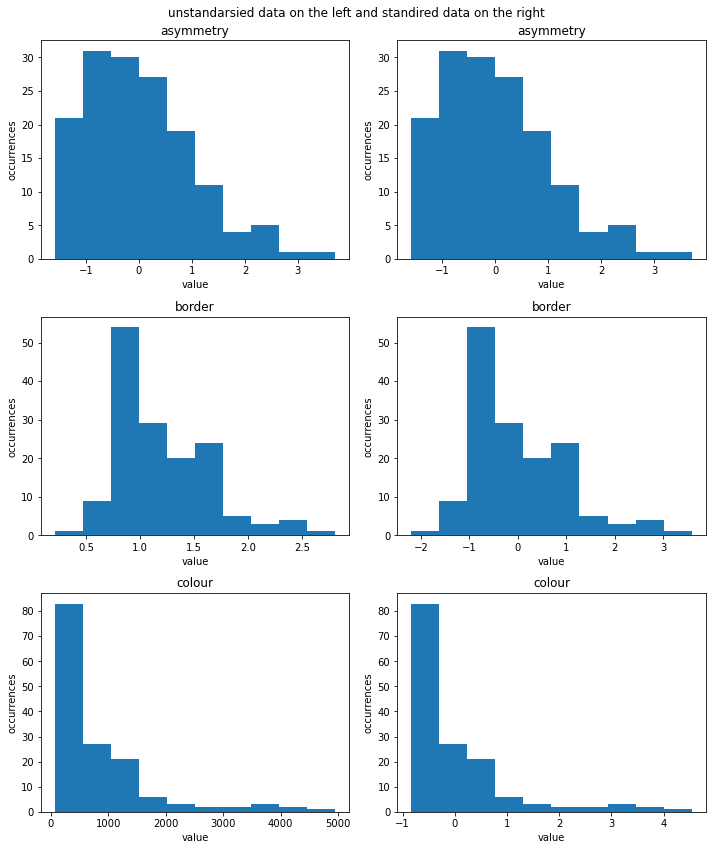

In [14]:
#comparison between standirised data and unstandardised data
fig, axs = plt.subplots(3,2,figsize=(10,12))
for i,feature in enumerate(features):
    
    plt.suptitle("unstandarsied data on the left and standired data on the right")
    # unstadiresd plot
    axs[i,0].hist(df_evaluations[feature])
    axs[i,0].set_title(feature)
    axs[i,0].set_xlabel('value')
    axs[i,0].set_ylabel('occurrences')
    
    #standarising
    mean = np.mean(df_evaluations[feature])
    sd = np.std(df_evaluations[feature])
    for n in range(df_evaluations.shape[0]):
        df_evaluations.at[n, feature] = (df_evaluations.at[n, feature] - mean) / sd
    
    #standirised plot
    axs[i,1].hist(df_evaluations[feature])
    axs[i,1].set_title(feature)
    axs[i,1].set_xlabel('value')
    axs[i,1].set_ylabel('occurrences')
    
fig.tight_layout()


In [16]:
df_evaluations.head()

,image_id,asymmetry,border,colour
0,ISIC_0001769,-0.023781,0.578983,-0.232156
1,ISIC_0001852,-0.709402,-0.476142,-0.420793
2,ISIC_0001871,0.612156,-0.442752,0.873516
3,ISIC_0003462,-1.365212,-1.012609,0.641374
4,ISIC_0003539,2.172190,-0.311418,-0.576170


In [17]:
df = df_conditions.drop('seborrheic_keratosis', axis=1).merge(df_evaluations, on='image_id').drop('image_id', axis=1)
print(df.head())

   melanoma  asymmetry    border    colour
0       0.0  -0.023781  0.578983 -0.232156
1       0.0  -0.709402 -0.476142 -0.420793
2       0.0   0.612156 -0.442752  0.873516
3       0.0  -1.365212 -1.012609  0.641374
4       0.0   2.172190 -0.311418 -0.576170


In [18]:
# Split dataset to select feature and evaluate the classifier
x = df[features]
y = df['melanoma']

# X_train and y_train used for training, X_val and y_val are for predicting and validating the ML model
x_train, x_val, y_train, y_val = train_test_split(
        x, y, stratify=y, test_size=0.4, random_state=0)
sm = SMOTE(random_state=0)
x_train, y_train = sm.fit_resample(x_train, y_train)

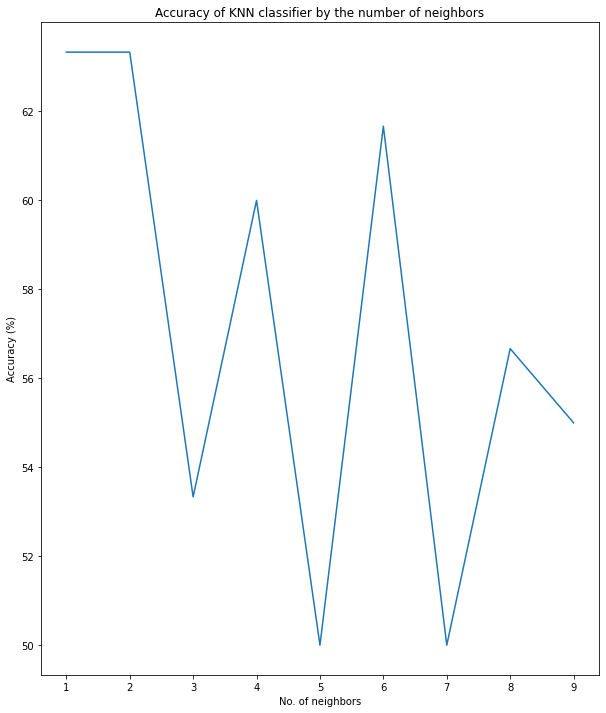

In [22]:
accuracy = [None]
sens = [None]
spec = [None]

# TODO

for n_neighbors in range(1, 10):
    # Train a classifier
    knn = KNeighborsClassifier(n_neighbors) # other hyperparameters possible
    knn_trained = knn.fit(x_train, y_train)
    y_val_knn = knn_trained.predict(x_val)
    # Accuracy - often used in ML but not suitable for medical imaging in general
    tn, fp, fn, tp = confusion_matrix(y_val, y_val_knn).ravel()
    accuracy.append(round(np.sum(y_val_knn == y_val) / np.size(y_val) * 100, 4))
    sens.append(round(sensitivity(tp, fn), 4))
    spec.append(round(specificity(tn, fp), 4))

    
accuracy

plt.figure(figsize=(10,12))
plt.plot(range(1, 10), accuracy[1:])
plt.title('Accuracy of KNN classifier by the number of neighbors')
plt.xlabel('No. of neighbors')
plt.ylabel('Accuracy (%)');

# Open question 

We decided to investigate whteter parametrs of our ML model would imporve if we increased training data. In order to do that we downloaded the data set of 2000 skin lessions images with corresponding masks from source website. 

Due to storage limit (2gb) at github, it is not possible to upload all images to the repository. Hence, in order to run the code one must download data from:
https://challenge.isic-archive.com/data/#2017

and adjust paths in the code below to run it. 

In [23]:
# Import a data frame with file names and associated diseases
df_conditions_oq = pd.read_csv('data/ISIC-2017_Training_Part3_GroundTruth.csv') # oq is an abreavaition for open question

# A new data frame is created, which will store results of ABC tests 
df_evaluations_oq = pd.DataFrame(df_conditions_oq['image_id'])
for name in features:
    df_evaluations_oq[name] = 0.0
    
for i in range(df_evaluations_oq.shape[0]):
    image, mask = crop(df_evaluations_oq.at[i, 'image_id'], True)
    df_evaluations_oq.at[i, 'asymmetry'] = asymmetry_score(mask)
    area, perimeter = measure_area_perimeter(mask)
    df_evaluations_oq.at[i, 'border'] = get_compactness(area, perimeter)
    r,g,b = colour_extraction(image)
    df_evaluations_oq.at[i,'colour'] = colour_variance_avg(r,g,b)

FileNotFoundError: [Errno 2] No such file or directory: 'data/ISIC-2017_Training_Part3_GroundTruth.csv'

# standarisation 

In [ ]:
for name in features:
    mean = np.mean(df_evaluations_oq[name])
    sd = np.std(df_evaluations_oq[name])
    for i in range(df_evaluations_oq.shape[0]):
        df_evaluations_oq.at[i, name] = (df_evaluations_oq.at[i, name] - mean) / sd

# 

In [ ]:
#merging data frames and droping irrelevant metric 
df_oq = df_conditions_oq.drop('seborrheic_keratosis', axis=1).merge(df_evaluations_oq, on='image_id').drop('image_id', axis=1)
print(df.head())

# Split dataset to select feature and evaluate the classifier
x = df_oq[features]
y = df_oq['melanoma']

# X_train and y_train used for training, X_val and y_val are for predicting and validating the ML model
x_train, x_val, y_train, y_val = train_test_split(
        x, y, stratify=y, test_size=0.4, random_state=0)
sm = SMOTE(random_state=0)
x_train, y_train = sm.fit_resample(x_train, y_train)

In [ ]:
accuracy = dict()

# TODO

for n_neighbors in [5]: #range(1, 10):
    # Train a classifier
    knn = KNeighborsClassifier(n_neighbors) # other hyperparameters possible
    knn_trained = knn.fit(x_train, y_train)
    y_val_knn = knn_trained.predict(x_val)
    # Accuracy - often used in ML but not suitable for medical imaging in general
    tn, fp, fn, tp = confusion_matrix(y_val, y_val_knn).ravel()
    accuracy[n_neighbors] = [np.sum(y_val_knn == y_val) / np.size(y_val) * 100, sensitivity(tp, fn), specificity(tn, fp)]
    
    
accuracy

# Scatters

In [ ]:
k = pd.read_csv("ManualDataAnalysis.csv")
name = k[0:51]
asymmetry = name.loc[:,"Asymmetry"]
border = name.loc[:,"Border"]
Color = name.loc[:,"Color"]
Filename = name.loc[:,"Filename"]
x = range(1,52)


In [ ]:
plt.figure(figsize=(12, 12), dpi=100)

plt.subplot(2,3,1)
plt.scatter(x,asymmetry,)
plt.title("Asymetry")

plt.subplot(2,3,2)
plt.scatter(x, border)
plt.title("Border")

plt.subplot(2,3,3)
plt.scatter(x, Color)
plt.title("Color")

plt.suptitle("Manual Analysis")

